# Microsoft Malware Detection


__Goal:__ Predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. It is really important to find out whether the computer is infected and cure it.




![](https://storage.googleapis.com/kaggle-competitions/kaggle/10683/logos/thumb76_76.png?t=2018-09-19-16-55-15)

## 1. Setup Environment

- Install the required packages 
- Import all the packages in 1st cell itself
- Set the options for data visualizations

In [ ]:
# Data Manipulation
import numpy as np 
import pandas as pd 

# Data Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# Track time
import time
import datetime

# Machine Learning
from   sklearn.preprocessing import LabelEncoder
from   sklearn.model_selection import train_test_split, GridSearchCV
from   sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve
from   sklearn.linear_model import LogisticRegression
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier
from   xgboost import XGBClassifier
from   lightgbm import LGBMClassifier
from   scipy.stats import chi2_contingency, f_oneway


import gc
import warnings
from   tqdm import tqdm_notebook


# Set Options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.style.use('ggplot')
py.init_notebook_mode(connected=False) # To work offline
warnings.filterwarnings("ignore")

##  2. Data Overview

The goal of this section is to :
- Load the malware dataset 
- Explore the features

Load the malware dataset using `pd.read_csv()`. File size is huge, so let's work on half data only i.e. 4000000 rows

In [ ]:
%%time
nrows = 4000000  # reduce if needed
train = pd.read_csv('Data/Input/malware_df.csv',
                    nrows = nrows)

In [ ]:
train.sample(6)

### Data Description

The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. 


The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.
Columns


Unavailable or self-documenting column names are marked with an "NA".
1.	__MachineIdentifier__ - Individual machine ID
2.	__ProductName__ - Defender state information e.g. win8defender
3.	__EngineVersion__ - Defender state information e.g. 1.1.12603.0
4.	__AppVersion__ - Defender state information e.g. 4.9.10586.0
5.	__AvSigVersion__ - Defender state information e.g. 1.217.1014.0
6.	__IsBeta__ - Defender state information e.g. false
7.	__RtpStateBitfield__ - NA
8.	__IsSxsPassiveMode__ - NA
9.	__DefaultBrowsersIdentifier__ - ID for the machine's default browser
10.	__AVProductStatesIdentifier__ - ID for the specific configuration of a user's antivirus software
11.	__AVProductsInstalled__ - NA
12.	__AVProductsEnabled__ - NA
13.	__HasTpm__ - True if machine has tpm
14.	__CountryIdentifier__ - ID for the country the machine is located in
15.	__CityIdentifier__ - ID for the city the machine is located in
16.	__OrganizationIdentifier__ - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
17.	__GeoNameIdentifier__ - ID for the geographic region a machine is located in
18.	__LocaleEnglishNameIdentifier__ - English name of Locale ID of the current user
19.	__Platform__ - Calculates platform name (of OS related properties and processor property)
20.	__Processor__ - This is the process architecture of the installed operating system
21.	__OsVer__ - Version of the current operating system
22.	__OsBuild__ - Build of the current operating system
23.	__OsSuite__ - Product suite mask for the current operating system.
24.	__OsPlatformSubRelease__ - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
25.	__OsBuildLab__ - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
26.	__SkuEdition__ - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.
27.	__IsProtected__ - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
28.	__AutoSampleOptIn__ - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9+
29.	__PuaMode__ - Pua Enabled mode from the service
30.	__SMode__ - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
31.	__IeVerIdentifier__ - NA
32.	__SmartScreen__ - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.
33.	__Firewall__ - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
34.	__UacLuaenable__ - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.
35.	vCensus_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible…)
36.	__Census_DeviceFamily__ - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
37.	__Census_OEMNameIdentifier__ - NA
38.	__Census_OEMModelIdentifier__ - NA
39.	__Census_ProcessorCoreCount__ - Number of logical cores in the processor
40.	__Census_ProcessorManufacturerIdentifier__ - NA
41.	__Census_ProcessorModelIdentifier__ - NA
42.	__Census_ProcessorClass__ - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
43.	__Census_PrimaryDiskTotalCapacity__ - Amount of disk space on primary disk of the machine in MB
44.	__Census_PrimaryDiskTypeName__ - Friendly name of Primary Disk Type - HDD or SSD
45.	__Census_SystemVolumeTotalCapacity__ - The size of the partition that the System volume is installed on in MB
46.	__Census_HasOpticalDiskDrive__ - True indicates that the machine has an optical disk drive (CD/DVD)
47.	__Census_TotalPhysicalRAM__ - Retrieves the physical RAM in MB
48.	__Census_ChassisTypeName__ - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
49.	__Census_InternalPrimaryDiagonalDisplaySizeInInches__ - Retrieves the physical diagonal length in inches of the primary display
50.	__Census_InternalPrimaryDisplayResolutionHorizontal__ - Retrieves the number of pixels in the horizontal direction of the internal display.
51.	__Census_InternalPrimaryDisplayResolutionVertical__ - Retrieves the number of pixels in the vertical direction of the internal display
52.	__Census_PowerPlatformRoleName__ - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
53.	__Census_InternalBatteryType__ - NA
54.	__Census_InternalBatteryNumberOfCharges__ - NA
55.	__Census_OSVersion__ - Numeric OS version Example - 10.0.10130.0
56.	__Census_OSArchitecture__ - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
57.	__Census_OSBranch__ - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fblpartnereeap where OsVersion = 6.4.9813.0.amd64fre.fblpartnereeap.140810-0005
58.	__Census_OSBuildNumber__ - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
59.	__Census_OSBuildRevision__ - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
60.	__Census_OSEdition__ - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
61.	__Census_OSSkuName__ - OS edition friendly name (currently Windows only)
62.	__Census_OSInstallTypeName__ - Friendly description of what install was used on the machine i.e. clean
63.	__Census_OSInstallLanguageIdentifie_r__ - NA
64.	__Census_OSUILocaleIdentifier__ - NA
65.	__Census_OSWUAutoUpdateOptionsName__ - Friendly name of the WindowsUpdate auto-update settings on the machine.
66.	__Census_IsPortableOperatingSystem__ - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
67.	__Census_GenuineStateName__ - Friendly name of OSGenuineStateID. 0 = Genuine
68.	__Census_ActivationChannel__ - Retail license key or Volume license key for a machine.
69.	__Census_IsFlightingInternal__ - NA
70.	__Census_IsFlightsDisabled__ - Indicates if the machine is participating in flighting.
71.	__Census_FlightRing__ - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
72.	__Census_ThresholdOptIn__ - NA
73.	__Census_FirmwareManufacturerIdentifier__ - NA
74.	__Census_FirmwareVersionIdentifier__ - NA
75.	__Census_IsSecureBootEnabled__ - Indicates if Secure Boot mode is enabled.
76.	__Census_IsWIMBootEnabled__ - NA
77.	__Census_IsVirtualDevice__ - Identifies a Virtual Machine (machine learning model)
78.	__Census_IsTouchEnabled__ - Is this a touch device ?
79.	__Census_IsPenCapable__ - Is the device capable of pen input ?
80.	__Census_IsAlwaysOnAlwaysConnectedCapable__ - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .
81.	__Wdft_IsGamer__ - Indicates whether the device is a gamer device or not based on its hardware combination.
82.	__Wdft_RegionIdentifier__ - NA



##  3. Optimize Memory Used by Data

In [ ]:
train.memory_usage(deep=True).sum() / 1024**2

In [ ]:
train.dtypes

Certain features occupy more memory than what is needed to store them. Reducing the memory usage by changing data type will speed up the computations.

Let's create a function for that:

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255
- bool : consumes 1 byte, true or false
- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535
- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647
- float64 / int64 / uint64: consumes 8 bytes of memory

In [ ]:
print('int64 min: ', np.iinfo(np.int64).min)
print('int64 max: ', np.iinfo(np.int64).max)

In [ ]:
print('int8 min: ', np.iinfo(np.int8).min)
print('int8 max: ', np.iinfo(np.int8).max)

In [ ]:
# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Use the defined function to reduce the memory usage

In [ ]:
# Reduce the memory size of the dataframe
train = reduce_mem_usage(train)

##  4. Understand the Data

Before attempting to solve the problem, it's very important to have a good understanding of data.

The goal of this section is to:
- Get the dimensions of data
- Get the summary of data
- Get various statistics of data

#### Shape of dataframe

In [ ]:
# Shape of dataframe
train.shape

The dataset has 4 million rows and 83 columns

In [ ]:
# Head of train df
train.head()

#### Summary of dataframe

In [ ]:
# Summary of dataframe
train.describe()

Some columns have missing values, let's look at the distribution of missing values by column and few more stats

#### More Stats on the dataframe

In [ ]:
# Stats of dataframe
stats    = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>


Lot of interesting things can be observed here:
* `PuaMode` and `Census_ProcessorClass` have 99%+ missing values,  which means that these columns are probably not helpful. So let's drop it for now;
* In `DefaultBrowsersIdentifier` column 95% values belong to one category, this columns is probably also not helpful;
* There are 26 columns in total in which one category contains 90% values. These imbalanced columns may optionally be removed from the dataset;
* Few columns like `Census_IsWIMBootEnabled` don't have any variance. These columns can to dropped.
* One more important point is that there are many columns which are considered to be numerical, but probably they are categorical - like `CityIdentifier`. Let's see more in further steps;


## 5. Data Preprocessing for EDA

The goal of this section is to:
- Drop columns based on the inferences from previous section
- Define the data type for categorical columns

In [ ]:
# Initial Shape
train.shape

In [ ]:
# Drop the columns which have more than 90% values missing
good_cols = list(train.columns)
for col in train.columns:
    missing_share = train[col].isnull().sum()/train.shape[0]
    if missing_share > 0.9:
        good_cols.remove(col)
        print("Removed: ", col)

Remove the columns where one category contains more than 90% values

In [ ]:
# Drop the columns where one category contains more than 90% values
for col in good_cols:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print("Removed: ", col)

Remove the columns which doesn't having any variance

In [ ]:
# Drop the columns which have only one unique value
for col in good_cols:
    unique_value = train[col].nunique()
    if unique_value == 1:
        good_cols.remove(col)
        print("Removed: ", col)

Select only the good columns

In [ ]:
# Filter the data for relevant columns only
train = train[good_cols]

In [ ]:
# Dimentions of data
train.shape

In [ ]:
# Export. Make sure 'Data/Intermediate' exists.
train.to_csv('Data/Intermediate/malware_df_clean.csv')

###  Define the data type for categorical columns
In practice, among the numerical variables, many corresponds to identifiers. In the current dataset, the truly numerical variables are in fact rare. Below, create a list of the variables which are truly numerical, according the data description.

In [ ]:
# Numeric columns
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges',
    'AVProductsInstalled'
]

List down binary variables. They can be treated as numericals by tree based algorithms

In [ ]:
# Binary columns
binary_columns = [c for c in train.columns if train[c].nunique() == 2]

Finally create a list of categorical columns

In [ ]:
# Categorical columns
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_columns)]

##  6. Exploratory Data Analysis

 - What is EDA
 - Purpose
 - Advantages and Importance


Exploratory data analysis is an approach to analyze data sets to find out patterns, insights and see if any of the variables can be useful in predicting the y variables. Visual methods are often used to summarize the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.



The goal of this section is to:
- Check proportion of columns by data type
- Encoding the categorical features
- Check if the target variable is balanced or is there a need to balance the target variable
- Understand the correlation of various features with each other, so that you understand which variables might be giving same information
- Get insights or relationships from the data which may be useful from business perspective
- Perform statistical significance test for categorical features

### Check proportion of columns by data type

In [ ]:
%%time
train = pd.read_csv('Data/Intermediate/malware_df_clean.csv',
                    nrows = nrows)

In [ ]:
train.head()

In [ ]:
train.drop(0, inplace=True)

In [ ]:
# Plot proportion of columns by data type using a pie chart
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_columns': len(binary_columns),
    'true_numerical_columns': len(true_numerical_columns)
}

# Plot
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout    = dict(title= "Variable types", height=400, width=800)
fig       = dict(data=[pie_trace], layout=layout)
py.iplot(fig)

**Inferences:**

Most of the current variables are categories. Depending on the cardinality of each variable, we will treat the columns differently. This we will see how to do in detail in the upcoming feature engineering step.

### Compute cardinality of categorical columns

In [ ]:
# PLot cardinality
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])

# Sort
cardinality.sort(key = lambda x:x[1], reverse=False)

# Plot
trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Top few variables having more than 20-30 categories. They seem to be identifiers (eg: city identifier). So let's remove the top few variables, then plot it. 

In [ ]:
# Plot Cardinality
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    if train[c].nunique() >= 30: 
        print("High cardinality: ", c)
        continue
    cardinality.append([c, train[c].nunique()])

    
# Sort
cardinality.sort(key = lambda x:x[1], reverse=False)


# Plot
trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

25 variables have high cardinality (more than 30 unique values). During feature engineering, we will treat them differently.


### Check distribution of target variable

In [ ]:
# Get count of target class
train['HasDetections'].value_counts()

In [ ]:
# Draw a countplot to check the distribution of target variable
sns.countplot(y=train['HasDetections'] ,data=train)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

The target variable is **balanced**, which is nice.

**What if the data has unbalanced classes?**
If it had not been balanced, you would have gone for balancing the class. Few ways to do so are :
- Upsampling
- Downsampling
- Hybrid sampling

### Check Correlations (Caution!)

You can plot a correlation matrix to check correlation between variables. Each cell in the matrix shows the correlation between two variables.

In [ ]:
# Let's check the correlations between all variables
plt.figure(figsize=(30,30))
p=sns.heatmap(train.corr(), annot=True,cmap='RdYlGn',center=0) 

It's time to deep dive in some of the most important variables and understand their relationship with target variable 

##  7. Understand Detection Rates by each Feature

Let's understand few functions first, which would be used in further analysis

In [ ]:
# Bar Plot
def frequency_plot_groupedby_y(col,top_n=10):
    top_n   = top_n if train[col].nunique() > top_n else train[col].nunique()
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=False).head())

    top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
    df_has_detection     = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
    df_no_detection      = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
    
    # Plot
    data    = [go.Bar(x=df_has_detection.index, y=df_has_detection.values, name='Has Detections'),
               go.Bar(x=df_no_detection.index, y=df_no_detection.values, name='No Detections')]

    layout  = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                        xaxis = dict(title = f'{col}',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,),
                        yaxis = dict(title = 'Counts',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,),
                        ),
                   legend=dict(orientation="v"), barmode='group')

    py.iplot(dict(data=data, layout=layout))

In [ ]:
frequency_plot_groupedby_y("Census_IsTouchEnabled",top_n=10)

### Detection Rate Plot

In [ ]:
# Detection rate = Count of machines with malware / Total machines

def plot_detection_rate(col,top_n=10):
    top_n   = top_n if train[col].nunique() > top_n else train[col].nunique()
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=True).head())

    top_cat               = list(train[col].value_counts(dropna=True).index[:top_n])
    top_cat_df            = train.loc[train[col].isin(top_cat)]

    df_touch_enabled      = top_cat_df.loc[top_cat_df['Census_IsTouchEnabled'] == 1]
    df_touch_disabled     = top_cat_df.loc[top_cat_df['Census_IsTouchEnabled'] == 0]

    df_touch_disabled     = df_touch_disabled.groupby([col]).agg({'HasDetections': ['count', 'mean']})
    df_touch_disabled     = df_touch_disabled.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
    df_touch_enabled      = df_touch_enabled.groupby([col]).agg({'HasDetections': ['count', 'mean']})
    df_touch_enabled      = df_touch_enabled.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()

    # Plot
    data1   = [go.Bar(x=df_touch_disabled.index, y=df_touch_disabled['HasDetections']['count'].values, name='Nontouch device counts'),
                go.Scatter(x=df_touch_disabled.index, y=df_touch_disabled['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
    data2   = [go.Bar(x=df_touch_enabled.index, y=df_touch_enabled['HasDetections']['count'].values, name='Touch device counts'),
                go.Scatter(x=df_touch_enabled.index, y=df_touch_enabled['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

    layout  = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                        xaxis = dict(title = f'{col}',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,
                                     type='category'),
                        yaxis = dict(title = 'Counts',
                                     showgrid=False,
                                     zeroline=False,
                                     showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                        ),
                   legend=dict(orientation="v"), barmode='group')

    py.iplot(dict(data=data1, layout=layout))
    layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
    py.iplot(dict(data=data2, layout=layout))

In [ ]:
plot_detection_rate("AVProductsInstalled", top_n=6)

In [ ]:
train.groupby('HasDetections')['AVProductsInstalled'].value_counts()

Rather than building different functions, let's create a single function which can be used for EDA for individual variables

In [ ]:
# define function for EDA for individual variables
def plot_categorical_feature(col, bars=False, top_n=10, by_touch=False):
    top_n = top_n if train[col].nunique() > top_n else train[col].nunique()
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=True).head())
    if not by_touch:
        top_cat = list(train[col].value_counts(dropna=True).index[:top_n])
        df_has_detection     = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
        df_no_detection      = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
        
        # Plot
        data    = [go.Bar(x=df_has_detection.index, y=df_has_detection.values, name='Has Detections'),
                   go.Bar(x=df_no_detection.index, y=df_no_detection.values, name='No Detections')]

        layout  = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                            ),
                       legend=dict(orientation="v"), barmode='group')
        
        py.iplot(dict(data=data, layout=layout))
        
    else:
        top_cat               = list(train[col].value_counts(dropna=True).index[:top_n])
        top_cat_df            = train.loc[train[col].isin(top_cat)]

        df_touch_enabled      = top_cat_df.loc[top_cat_df['Census_IsTouchEnabled'] == 1]
        df_touch_disabled     = top_cat_df.loc[top_cat_df['Census_IsTouchEnabled'] == 0]

        df_touch_disabled     = df_touch_disabled.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df_touch_disabled     = df_touch_disabled.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        df_touch_enabled      = df_touch_enabled.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df_touch_enabled      = df_touch_enabled.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        data1   = [go.Bar(x=df_touch_disabled.index, y=df_touch_disabled['HasDetections']['count'].values, name='Nontouch device counts'),
                    go.Scatter(x=df_touch_disabled.index, y=df_touch_disabled['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
        data2   = [go.Bar(x=df_touch_enabled.index, y=df_touch_enabled['HasDetections']['count'].values, name='Touch device counts'),
                    go.Scatter(x=df_touch_enabled.index, y=df_touch_enabled['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

        layout  = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,
                                         type='category'),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                                    yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                            ),
                       legend=dict(orientation="v"), barmode='group')

        py.iplot(dict(data=data1, layout=layout))
        layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
        py.iplot(dict(data=data2, layout=layout))

### Feature: Census_IsTouchEnabled

In [ ]:
# Only bars
plot_categorical_feature(col='Census_IsTouchEnabled', bars=True)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- As expected Microsoft has much more computers that touch devices. 
- The rate of infections is slightly lower for touch devices.

### Feature: AVProductsInstalled

In [ ]:
# Only bars
plot_categorical_feature(col='AVProductsInstalled', bars=True)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Hm, interesting. 

If a computer has more than one antivirus, it is less likely to be infected. Here the devices which has more than 1 antivirus have less chances of being infected.

In [ ]:
# Both bars and detection rate
plot_categorical_feature(col='AVProductsInstalled', bars=True, by_touch=True)

In [ ]:
train['AVProductsInstalled'].value_counts()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- People sometimes install 2 antiviruses, even on touch devices.
- The number of devices with 6 antiviruses is just 1 and that got infected as well. That's why the detection rate is so high. Chances are those AVs were installed by the user after the infection or some sort of malware experiment. Just my guess.

### Feature: OsPlatformSubRelease

In [ ]:
plot_categorical_feature(col='OsPlatformSubRelease', bars = True, by_touch = True)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Most computers have Windows 10 (rs*). I suppose Microsoft specifically chose them, so that analysis is focussed on modern devices?

- The detection rate has increased for later 'rs' subreleases.

### Feature: Census_ProcessorCoreCount

In [ ]:
plot_categorical_feature(col = 'Census_ProcessorCoreCount', bars=True, by_touch = True)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Most computers have 2, 4 or 8 cores. For touch devices 4 cores are much more common than other configurations. And these 3 variants cover 95% of devices

- The detection rate (across different processor corecounts) appear to be __fairly uniform for touch devices.__ 

- The detection rate seems to __improve (decrease) with processor count for non-touch devices.__

### Feature: Census_TotalPhysicalRAM

In [ ]:
plot_categorical_feature(col = 'Census_TotalPhysicalRAM', bars = True, by_touch = True)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- With bigger RAM size the detection rate also seem to increase till a certain point.
- Most computers have <=8 Gb RAM. Quite interesting.

### Feature: Census_InternalPrimaryDiagonalDisplaySizeInInches

In [ ]:
plot_categorical_feature(col = 'Census_InternalPrimaryDiagonalDisplaySizeInInches', bars = True, by_touch = True)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Surprising that most computers have 15.5 inch screens. 
- There seem to be an increasing pattern in detection rate for non-touch devices.

### Feature: Census_PowerPlatformRoleName

In [ ]:
train['Census_PowerPlatformRoleName'].value_counts(dropna=False, normalize=True).cumsum()

In [ ]:
plot_categorical_feature(col = 'Census_PowerPlatformRoleName', bars = True)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

For some reason slates have quite a low rate of detections. Maybe no hackers are interested in them? :)

**I have analysed few of the most important variables individually. It's a good idea to get some practice with other variables as well for further analysis.**

## Analyze numerical columns (grouped by target class)

In [ ]:
for cols in true_numerical_columns:
    
    # Remove outliers
    Q1 = train[[cols]].quantile(0.25)
    Q3 = train[[cols]].quantile(0.75)
    IQR = Q3 - Q1

    df = train[~((train[[cols]] < (Q1 - 1.5 * IQR)) |(train[[cols]] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # Draw Plot
    plt.figure(figsize=(5,5), dpi= 100)
    sns.boxplot(x='HasDetections', y=cols, data=df, notch=False)
    plt.title('Box Plot of ' + cols +  ' by Detection Class', fontsize=10)
    plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- In case of `AVProductsInstalled`, it can be clearly seen that higher number of antivirus, lesser the chances of being infected.

- For PrimaryDiskTotalCapacity, there is an indication of high capacity implying higher detection rate.

## 8. Statistical Significance Test


### Chi sqare test for categorical columns

Understand whether a given categorical feature has a statistical significant relationship with the Y (`HasDetections`)

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
# significance value
alpha = 0.05

significant_categorical_variables = []
for col in categorical_columns[1:] + binary_columns:
    temp = pd.crosstab(train[col],train['HasDetections'].astype('category'))
    
    # Chi-square stat , p-value, degrees of freedom, expected frequencies
    stat, p, dof, expected = chi2_contingency(temp)
    print(col.ljust(40), ',  chisquared=%.5f,   p-value=%.5f' % (stat, p))
    
    # Determine whether to reject or keep your null hypothesis
    if p <= alpha:
        significant_categorical_variables.append(col)

In [ ]:
# See Significant variables
print(significant_categorical_variables)

#### View cross tabulation and calc odds

In [ ]:
ctab = pd.crosstab(train['Processor'],train['HasDetections'].astype('category'))
ctab

#### Odds

In [ ]:
# Calc odds
ctab.columns = ctab.columns.add_categories('odds')
ctab['odds'] = ctab[1] / ctab[0]
ctab

#### Odds Ratio

In [ ]:
# Calc odds ratio = Odds / (sum of all 1's / sum of all 0's)
ctab.columns = ctab.columns.add_categories('odds_ratio')
ctab['odds_ratio'] = ctab['odds'] / (ctab[1].sum()/ctab[0].sum())
ctab

##  ANOVA test

#### ANOVA with scipy.stats api

In [ ]:
# significance value
alpha = 0.05

significant_numerical_variables = []
for col in true_numerical_columns:
    # Get F and p value
    F, p = f_oneway(train[train.HasDetections == 1][col].dropna(),
                    train[train.HasDetections == 0][col].dropna())
    
    # Determine whether to reject or keep null hypothesis
    print(col.ljust(50), ',   F-statistic=%.5f, p=%.5f' % (F, p))
    if p <= alpha:
        significant_numerical_variables.append(col)

In [ ]:
out = f_oneway(train[train.HasDetections == 1][col].dropna(),
                    train[train.HasDetections == 0][col].dropna())

out

In [ ]:
# See Significant variables
print(significant_numerical_variables)

#### ANOVA with statsmodels api

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

Fit ANOVA model

In [ ]:
model = ols('Census_ProcessorCoreCount ~ C(HasDetections)', train).fit()
print(f"Overall model F({model.df_model: .0f}, {model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

# ANOVA table
res = sm.stats.anova_lm(model, typ=2)
res

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> EDA Inferences:</h3>
</div>

- The target class in balanced
- More than 85% columns are either categorical or binary, only 14.6% columns are numerical
- There are few columns which have more than 30 categories which are identifiers
- Number of non touch devices is way higher than touch devices, which is quite expected as Microsoft deals with computers mainly
- Rate of infection is lower for touch devices
- If a device has more than one antivirus, it is less likely to be infected
- Most of the devices have Windows 10 installed
- Most devices have 2, 4 or 8 cores. For touch devices 4 cores are much more common than other configurations. And these 3 variants cover 95% of devices
- It's very surprising that most of devices have 15 inch screens. And this is a rare situation, when for some categories detection rate on non touch devices is higher than on touch devices
- Slates have very lower rate of infection 
- No clear differentiation can be seen in the distribution of numerical columns group by categories

## Mini Challenge

Analyze the following variables and draw out the inferences :
- CountryIdentifier
- Census_OSVersion
- Census_OSInstallTypeName
- AvSigVersion
- Census_PrimaryDiskTotalCapacity

##  7. Feature Engineering

Feature engineering is the process of using domain knowledge to extract or create new features from raw data via data mining techniques. 

Features that help to better explain the 'Y', often improve the performance of machine learning algorithms. 


__Two main types:__
1. Domain specific features
2. Encodings of categorical features

In [ ]:
train.head()

## Domain Specific Features

Domain specific features are those that has some intrinsic meaning associated to the problem domain. This might boost up the predictive power, often giving better performing models. 

It is easier to explain to stakeholders, sometimes bringing in new insights enabling better understanding of the problem.

Domain knowledge is one of the key pillars of data science. So always understand the domain when attempting the problem.

#### Engineer features from Engine Version

In [ ]:
# Engine Version
train['EngineVersion_2'] = train['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['EngineVersion_3'] = train['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

#### Engineer features from App Version

In [ ]:
# App version 
train['AppVersion_1'] = train['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['AppVersion_2'] = train['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['AppVersion_3'] = train['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

#### Engineer features from Anti Virus Sig Version

In [ ]:
# Anti Virus Version
train['AvSigVersion_0'] = train['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
train['AvSigVersion_1'] = train['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['AvSigVersion_2'] = train['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train.head()

#### Engineer features from Operating System Build Lab

In [ ]:
# Operating System Lab

# Replace NA values of 'OsBuildLab' column with '0.0.0.0-0'
train['OsBuildLab']   = train['OsBuildLab'].fillna('0.0.0.0.0-0')

train['OsBuildLab_0'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
train['OsBuildLab_1'] = train['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
train['OsBuildLab_2'] = train['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
train['OsBuildLab_3'] = train['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

#### Engineer features from Operating System Version

In [ ]:
# Operating System Version
train['Census_OSVersion_0'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
train['Census_OSVersion_1'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['Census_OSVersion_2'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['Census_OSVersion_3'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

#### Engineer storage features

In [ ]:
# Storage 
train['primary_drive_c_ratio'] = train['Census_SystemVolumeTotalCapacity'] / train['Census_PrimaryDiskTotalCapacity']
train['non_primary_drive_MB']  = train['Census_PrimaryDiskTotalCapacity'] - train['Census_SystemVolumeTotalCapacity']
train.head()

#### Engineer display features

In [ ]:
# Aspect Ratio 
train['aspect_ratio'] = train['Census_InternalPrimaryDisplayResolutionHorizontal']/ train['Census_InternalPrimaryDisplayResolutionVertical']
train.head()

#### Engineer monitor dimensions features - categorical

In [ ]:
# Monitor Dimensions
train['monitor_dims'] = train['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(str) + '*' + train['Census_InternalPrimaryDisplayResolutionVertical'].astype('str')
train['monitor_dims'] = train['monitor_dims'].astype('category')
train.head()

#### Engineer DPI features

In [ ]:
# DPI
train['dpi']        = ((train['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + train['Census_InternalPrimaryDisplayResolutionVertical']**2)**.5)/(train['Census_InternalPrimaryDiagonalDisplaySizeInInches'])
train['dpi_square'] = train['dpi'] ** 2
train.head()

#### Engineer MP feature

In [ ]:
# MP
train['MegaPixels'] = (train['Census_InternalPrimaryDisplayResolutionHorizontal'] * train['Census_InternalPrimaryDisplayResolutionVertical'])/1e6
train.head()

#### Engineer Screen Area feature

In [ ]:
# Screen Area
train['Screen_Area'] = (train['aspect_ratio']* (train['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(train['aspect_ratio']**2 + 1)
train.head()

#### Engineer RAM per processor feature

In [ ]:
# RAM per processor
train['ram_per_processor'] = train['Census_TotalPhysicalRAM']/ train['Census_ProcessorCoreCount']
train.head()

#### Engineer few numeric features (arbitrary)

In [ ]:
train['new_num_0'] = train['Census_InternalPrimaryDiagonalDisplaySizeInInches'] / train['Census_ProcessorCoreCount']
train['new_num_1'] = train['Census_ProcessorCoreCount'] * train['Census_InternalPrimaryDiagonalDisplaySizeInInches']
train.head()

## Feature Encoding

Encoding is the process of converting data from one form to another. Most of the Machine learning algorithms can not handle categorical values unless we convert them to numerical values. Many algorithm’s performances vary based on how Categorical columns are encoded.


### Frequency Encoding

- **Frequency Encoding**  - It is a way to utilize the frequency of the categories as label values. In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on nature of the data.

In [ ]:
# Add the engineered features to the variable caterorical_columns
categorical_columns = categorical_columns + ['EngineVersion_2', 'EngineVersion_3',
       'AppVersion_1', 'AppVersion_2', 'AppVersion_3', 'AvSigVersion_0',
       'AvSigVersion_1', 'AvSigVersion_2', 'OsBuildLab_0', 'OsBuildLab_1',
       'OsBuildLab_2', 'OsBuildLab_3', 'Census_OSVersion_0',
       'Census_OSVersion_1', 'Census_OSVersion_2', 'Census_OSVersion_3',
       'monitor_dims']

Create a list of variables that needs to be encoded using frequency encoding. 

Let's note down the features which has __more than 30 unique values__ as these are probably identifiers. Let's use frequency encoding for such features.

In [ ]:
# Frequecny encoding variables
frequency_encoded_variables = []
for col in categorical_columns:
    if train[col].nunique() > 30:
        print(col, train[col].nunique())
        frequency_encoded_variables.append(col)

Remove machine identifier from the list of columns as it is the unique key and we will not be using it for encoding and modelling

In [ ]:
# Remove machine identifier from list
frequency_encoded_variables.remove("MachineIdentifier")
categorical_columns.remove('MachineIdentifier')

Convert the data type of categorical variables to category as there were mismatch in dtype 

In [ ]:
# Convert dtype of categorical variables to category
for col in categorical_columns:
    train[col] = train[col].astype('category')

In [ ]:
# Print head of train df
train.head()

It's time to encode the variables using frequency encoding

In [ ]:
%%time
# Frequecny enocde the variables
for variable in tqdm_notebook(frequency_encoded_variables):
    # group by frequency 
    fq = train.groupby(variable).size()/len(train)    
    
    # mapping values to dataframe 
    train.loc[:, "{}".format(variable)] = train[variable].map(fq)   
    categorical_columns.remove(variable)

In [ ]:
train.head()

### Label Encoding

- **Label encoding** - Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.



In [ ]:
%%time
indexer = {}
for col in tqdm_notebook(categorical_columns):
    _, indexer[col] = pd.factorize(train[col])
    train[col] = indexer[col].get_indexer(train[col])

In [ ]:
train.head()

In [ ]:
print(col)

Let's reduce the memory usage as lot of new columns has been added to the data frame

In [ ]:
train = reduce_mem_usage(train)

## 8. Data Preprocessing for model building


The goal of this section is to:
- Drop data which we are not gonna use while building the models
- Split the dataset in training and test sets


**Tip : Save the train df, and clean all memory**

In [ ]:
# Save train df to csv file 
# train.to_csv("Data/Intermediate/training_df_processed.csv",index = False)

# Read train df
train = pd.read_csv("Data/Intermediate/training_df_processed.csv")

In [ ]:
train.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Print shape of data frame
train.shape

In [ ]:
train.head()

### Clean Data

In [ ]:
# Remove Machine Identifier column
train = train.drop(['MachineIdentifier'], axis=1)

### Treat Na values. 
1. Remove the columns which have more than 20% na values. 
2. Later remove the rows which has na values. (since we have a lot of records in dataset).

In [ ]:
# na value treatment
for col in train:
    missing_value_percent = train[col].isnull().sum() * 100 / train.shape[0]
    if missing_value_percent >= 20:
        train.drop(col,axis=1, inplace = True)
    else:
        train = train[train[col].notna()]

Check how many rows and columns have been removed

In [ ]:
# Print shape of data frame
train.shape

Seperate the x variables and y variables

#### Split X and y dataset

In [ ]:
# Split the y variable series and x variables dataset
X = train.drop(['HasDetections'],axis=1)
y = train.HasDetections

# Delete train df
del train
gc.collect()

Split the dataset into train set and test set. Train set will be used to train the model. Test set will be used to check the performance of model

#### Train Test Split

In [ ]:
# Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
X_train.head()

##  9. Model Building

Finally, model building starts.

Let's start with Logistic Regression

## Logistic Regression

Logistic regression is a predictive model which can be used when the y/dependent variable is binary. 

In [ ]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression

#### Scale the X variables

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X_ = scaler.transform(X)

In [ ]:
# Check
mx = np.apply_along_axis(np.max, 0, X_)
mi = np.apply_along_axis(np.min, 0, X_)
print(mx)
print(mi)

In [ ]:
X_train_, X_test_, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state = 0)

In [ ]:
%%time
# Defining the model
lr = LogisticRegression(random_state=0)

# Training the model:
lr.fit(X_train_, y_train)

lr

#### Examine Coefs

In [ ]:
# Examine coefs
lr_coefs = [(col, coef) for col, coef in zip(X_train.columns[1:], lr.coef_[0])]
sorted(lr_coefs, key = lambda x: -x[1])

Let's use the model to get predictions on test dataset. Let's get predicted class and predicted probability both in order to evaluate the performance of the model

#### Top 25 columns

In [ ]:
# Extract impactful columns (large coefs)
lr_coefs = [(col, coef, pos) for pos, (col, coef) in enumerate(zip(X_train.columns[1:], lr.coef_[0]))]
top_ = sorted(lr_coefs, key = lambda x: -abs(x[1]))[:25]
top_columns = [name for name, coef, pos in top_]
top_column_pos = [pos for name, coef, pos in top_]

print(top_columns, "\n")
print(top_column_pos)

### Prediction Probability Scores

In [ ]:
# Predict probability for test dataset
y_prob_lr = lr.predict_proba(X_test_)
y_prob_lr

### Prediction

In [ ]:
# Predict class for test dataset
y_pred_lr = lr.predict(X_test_)
y_pred_lr

In [ ]:
y_prob_lr = [x[1] for x in y_prob_lr]
print("Y predicted : ",y_pred_lr)
print("Y probability predicted : ",y_prob_lr[:5])

#### Logistic Regression with statsmodels api

In [ ]:
# importing libraries 
import statsmodels.api as sm 
import pandas as pd  
       
# building the model and fitting the data 
log_reg = sm.Logit(y_train, X_train_[:, top_column_pos]).fit() 

In [ ]:
print(log_reg.summary()) 

In [ ]:
yhat = log_reg.predict(X_test_[:, top_column_pos]) 
print(yhat[:5])

pred = np.round(yhat)
<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Model Building</h2>
</div>
print(pred)

## Evaluation Metrics


Let's compute various evaluation metrics now

- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve

In [ ]:
print("\n Confusion Matrix : \n",confusion_matrix(y_test, y_pred_lr))
print("\n Classification Report : \n",classification_report(y_test, y_pred_lr))

### Concordance

Scikit learn does not have a function for this at the moment. So, let make one. 

In [ ]:
# Compute Concordance
from bisect import bisect_left, bisect_right

actuals = y_test.values
preds_probs = lr.predict_proba(X_test_)
preds = [x[1] for x in preds_probs]


def concordance(actuals, preds):
    ones_preds  = [p for a,p in zip(actuals, preds) if a == 1]
    zeros_preds = [p for a,p in zip(actuals, preds) if a == 0]
    n_ones = len(ones_preds)
    n_total_pairs =  float(n_ones) * float(len(actuals) - n_ones)
    # print("Total Pairs: ", n_total_pairs)

    zeros_sorted = sorted(zeros_preds)

    conc = 0; disc = 0; ties = 0;
    for i, one_pred in enumerate(ones_preds):
        cur_conc = bisect_left(zeros_sorted, one_pred)
        cur_ties = bisect_right(zeros_sorted, one_pred) - cur_conc
        conc += cur_conc
        ties += cur_ties
        disc += float(len(zeros_sorted)) - cur_ties - cur_conc

    concordance = conc/n_total_pairs
    discordance = disc/n_total_pairs
    ties_perc = ties/n_total_pairs
    print(round(concordance, 2), round(discordance, 2), ties_perc)
    return concordance

In [ ]:
concordance(y_test, y_prob_lr)

#### Combine evaluation metrics in one function and report it.

In [ ]:
def compute_evaluation_metric(model, x_test, y_actual, y_predicted, y_predicted_prob):
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n AUC Score : ", roc_auc_score(y_actual, y_predicted_prob))
    print("\n Confusion Matrix : \n",confusion_matrix(y_actual, y_predicted))
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))
    print("\n Concordance Index : ", concordance(y_actual, y_predicted_prob))

    print("\n ROC curve : \n")
    plot_roc_curve(model, x_test, y_actual)
    plt.show() 

    print("\n PR curve : \n")
    plot_precision_recall_curve(model, x_test, y_actual)
    plt.show() 

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["figure.dpi"] = 100

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(lr, X_test_, y_test, y_pred_lr, y_prob_lr)

## Capture Rates, Gains Table

Divide the data in 10 equal bins as per predicted probability scores. Then, compute the percentage of the total target class 1 captured in every bin. 

Ideally the proportion should be decreasing as we go down ever bin.
Let's check it out

#### Create validation set

In [ ]:
# Create Validation set
validation_df = {'y_test' : y_test, 'y_pred' : y_pred_lr, 'y_pred_prob' : y_prob_lr}
validation_df = pd.DataFrame(data = validation_df)

# Create 10 equal sized bins and add it as new column
validation_df['bin_y_pred_prob'] = pd.qcut(validation_df['y_pred_prob'], q=10)
validation_df.head()

In [ ]:
# Change x label
x_label = []

for i in range(len(validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str'))):
    x_label.append("Bin" + str(i + 1)+ "(" + validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str')[i] + ")")

#### Capture Rates Plot

In [ ]:
# Plot Distribution of predicted probabilities for every bin
plt.figure(figsize=(12, 8));
sns.stripplot(validation_df.bin_y_pred_prob, validation_df.y_pred_prob, jitter = 0.15, hue = validation_df.y_test, order = validation_df['bin_y_pred_prob'].cat.categories[::-1])
plt.title("Distribution of predicted probabilities for every bin", fontsize=18)
plt.xlabel("Predicted Probability Bins", fontsize=14);
plt.ylabel("Predicted Probability", fontsize=14);
plt.xticks(np.arange(10), x_label, rotation=45);
plt.show()

#### Gains Table

In [ ]:
# Aggregate the data
validation_df                        = validation_df.groupby(["bin_y_pred_prob","y_test"]).agg({'y_test': ['count']})
validation_df.columns                = validation_df.columns.map(''.join)
validation_df['prob_bin']            = validation_df.index.get_level_values(0)
validation_df['y_test']              = validation_df.index.get_level_values(1)
validation_df.reset_index(drop = True, inplace = True)


# Get infection rate and percentage infections
validation_df                        = validation_df.pivot(index='prob_bin', columns='y_test', values='y_testcount')
validation_df['prob_bin']            = validation_df.index
validation_df                        = validation_df.iloc[::-1]
validation_df['prob_bin']            = x_label
validation_df.reset_index(drop       = True, inplace = True)
validation_df                        = validation_df[['prob_bin', 0, 1]]
validation_df.columns                = ['prob_bin', "non_infections", "infections"]
validation_df['perc_infections']     = validation_df['infections']/validation_df['infections'].sum()
validation_df['perc_non_infections'] = validation_df['non_infections']/validation_df['non_infections'].sum()
validation_df['cum_perc_infection'] = 100*(validation_df.infections.cumsum() / validation_df.infections.sum()) 
validation_df['cum_perc_non_infection'] = 100*(validation_df.non_infections.cumsum() / validation_df.non_infections.sum()) 

In [ ]:
# View Gains Table
validation_df

In [ ]:
# Plot
plt.figure(figsize=(12, 8));
sns.set_style("white")
sns.pointplot(x = "prob_bin", y = "cum_perc_infection", data = validation_df, legend = False, order=validation_df.prob_bin)
plt.xticks(rotation=45);
plt.ylabel("Infection Rate", fontsize=14)
plt.xlabel("Prediction probability bin", fontsize=14)
plt.title("Infection rate for every bin", fontsize=18)
plt.show()

Ideally the slope should be high initially and should decrease as we move further to the right. This is not really a good model.

In [ ]:
# One big function.
def captures(y_test, y_pred, y_prob_pred):
    # Create Validation set
    validation_df = {'y_test' : y_test, 'y_pred' : y_pred, 'y_pred_prob' : y_prob_pred}
    validation_df = pd.DataFrame(data = validation_df)

    # Add binning column to the dataframe
    validation_df['bin_y_pred_prob'] = pd.qcut(validation_df['y_pred_prob'], q=10)
    # Change x label and column names
    x_label = []
    for i in range(len(validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str'))):
        x_label.append("Bin" + str(i + 1)+ "(" + validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str')[i] + ")")
    
    # Plot Distribution of predicted probabilities for every bin
    plt.figure(figsize=(12, 8));
    sns.stripplot(validation_df.bin_y_pred_prob, validation_df.y_pred_prob, jitter = 0.15, hue = validation_df.y_test, order = validation_df['bin_y_pred_prob'].cat.categories[::-1])
    plt.title("Distribution of predicted probabilities for every bin", fontsize=18)
    plt.xlabel("Predicted Probability Bins", fontsize=14);
    plt.ylabel("Predicted Probability", fontsize=14);
    plt.xticks(np.arange(10), x_label, rotation=45);
    plt.show()
    
    # Aggregate the data
    validation_df             = validation_df.groupby(["bin_y_pred_prob","y_test"]).agg({'y_test': ['count']})
    validation_df.columns     = validation_df.columns.map(''.join)
    validation_df['prob_bin'] = validation_df.index.get_level_values(0)
    validation_df['y_test']   = validation_df.index.get_level_values(1)
    validation_df.reset_index(drop = True, inplace = True)
    
    # Get infection rate and percentage infections
    validation_df = validation_df.pivot(index='prob_bin', columns='y_test', values='y_testcount')
    validation_df['prob_bin'] = validation_df.index
    validation_df = validation_df.iloc[::-1]
    validation_df['prob_bin'] = x_label
    validation_df.reset_index(drop = True, inplace = True)
    validation_df = validation_df[['prob_bin', 0, 1]]
    validation_df.columns = ['prob_bin', "non_infections", "infections"]
    validation_df['perc_infections'] = validation_df['infections']/validation_df['infections'].sum()
    validation_df['perc_non_infections'] = validation_df['non_infections']/validation_df['non_infections'].sum()
    validation_df['cum_perc_infection'] = 100*(validation_df.infections.cumsum() / validation_df.infections.sum()) 
    validation_df['cum_perc_non_infection'] = 100*(validation_df.non_infections.cumsum() / validation_df.non_infections.sum()) 
    
    # Plot for cumulative percentage infections
    plt.figure(figsize=(12, 8));
    sns.set_style("white")
    sns.pointplot(x = "prob_bin", y = "cum_perc_infection", data = validation_df, legend = False, order=validation_df.prob_bin)
    plt.xticks(rotation=45);
    plt.ylabel("Infection Rate", fontsize=14)
    plt.xlabel("Prediction probability bin", fontsize=14)
    plt.title("Infection rate for every bin", fontsize=18)
    plt.show()
    
    return validation_df

In [ ]:
# Gains Table and Capture rates plot
captures(y_test, y_pred_lr, y_prob_pred_lr)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- The accuracy score is 0.5 and AUC score is 0.53. These scores are very less
- ROC curve is almost linear which is bad
- The model is always predicting the class as 1, which is very bad



Let's explore tree based models to see if we would be able to increase the performance. We will start with Decision Trees 

## Decision Tree

Decision tree is a popular algorithm for classification and prediction. A Decision tree is a flowchart like tree structure, where each internal node denotes a split on an particular feature,and the split is determined so that it maximizes the information gain on the y variable. Each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

__Example Decision Tree:__

![decision_tree.PNG](decision_tree.jpg)

image credits: wikipedia

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [ ]:
%%time
# Define the model
dt = DecisionTreeClassifier(random_state=0)

# Train the model
dt.fit(X_train, y_train)

dt

In [ ]:
colnames_list = X_train.columns.values.tolist()
r = export_text(dt, feature_names=colnames_list)
print(r)

#### Visualize

In [ ]:
# Visualize
# tree.plot_tree(dt)

Let's use the model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

#### Prediction

In [ ]:
# Predictions
y_pred_dt = dt.predict(X_test)
y_prob_pred_dt = dt.predict_proba(X_test)
y_prob_pred_dt = [x[1] for x in y_prob_pred_dt]
print("Y predicted : ",y_pred_dt[:10])
print("Y probability: ",y_prob_pred_dt[:10])

#### Confusion matrix and report

In [ ]:
print("\n Confusion Matrix : \n", confusion_matrix(y_test, y_pred_dt))
print("\n Classification Report : \n", classification_report(y_test, y_pred_dt))

#### Evaluation Metrices

Let's compute various evaluation metrics now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(dt, X_test, y_test, y_pred_dt, y_prob_pred_dt)

In [ ]:
# Depth of Decision Tree
print(dt.tree_.max_depth)

### Decision Tree with max_depth = 32

In [ ]:
%%time

# Define the model
dt = DecisionTreeClassifier(random_state=0, max_depth = 32)

# Train the model
dt.fit(X_train, y_train)
dt

Let's use the model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

#### Prediction

In [ ]:
# Predictions
y_pred_dt = dt.predict(X_test)
y_prob_pred_dt = dt.predict_proba(X_test)
y_prob_pred_dt = [x[1] for x in y_prob_pred_dt]
print("Y predicted : ",y_pred_dt)
print("Y probability predicted : ",y_prob_pred_dt[:5])

In [ ]:
# Visualize
# tree.plot_tree(dt)

#### Evaluation Metrices

Let's compute various evaluation metrics now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

In [ ]:
print("\n Confusion Matrix : \n", confusion_matrix(y_test, y_pred_dt))
print("\n Classification Report : \n", classification_report(y_test, y_pred_dt))

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(dt, X_test, y_test, y_pred_dt, y_prob_pred_dt)

### Decision Tree with max_depth = 16

In [ ]:
%%time
# Define the model
dt = DecisionTreeClassifier(random_state=0, max_depth = 16)

# Train the model
dt.fit(X_train,y_train)

dt

Let's use the model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

#### Prediction

In [ ]:
# Predictions
y_pred_dt = dt.predict(X_test)
y_prob_pred_dt = dt.predict_proba(X_test)
y_prob_pred_dt = [x[1] for x in y_prob_pred_dt]
print("Y predicted : ",y_pred_dt)
print("Y probability predicted : ",y_prob_pred_dt[:5])

In [ ]:
# Visualize
# fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, feature_names=X_train.columns.values.tolist(),  
                   filled=True)

#### Evaluation Metrices

Let's compute various evaluation metrics now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(dt, X_test, y_test, y_pred_dt, y_prob_pred_dt)

#### Capture Rates

In [ ]:
# Validate with probability bins
captures(y_test, y_pred_dt, y_prob_pred_dt)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Decision tree with max_depth == 16 is the best decision tree model
- The accuracy score is 0.63, AUC and concordence scores are 0.68. These scores are better as compared to logisitic regression model
- ROC and PR curve has also improved

Performance has improved as compared to logistic regression. But it's still not upto the mark. Hence single decision tree model is not a right fit for this problem. What next ? What about a group of decision trees. 

Let's look at Random Forest

## Random Forest

Random forest is a bagging algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

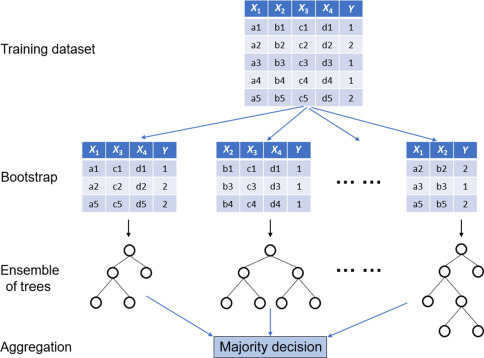

image credits : sciencedirect.com/topics/engineering/random-forest

In [ ]:
%%time
# Define the model
rf = RandomForestClassifier(random_state=0, n_jobs = -1)

# Train the model
rf.fit(X_train,y_train)

rf

Let's use the model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

#### Prediction

In [ ]:
# Prediction
y_pred_rf = rf.predict(X_test)
y_prob_pred_rf = rf.predict_proba(X_test)
y_prob_pred_rf = [x[1] for x in y_prob_pred_rf]
print("Y predicted : ", y_pred_rf)
print("Y probability predicted : ", y_prob_pred_rf[:5])

#### Evaluation Metrices

Let's compute various evaluation metrices now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

#### Confusion matrix and report

In [ ]:
print("\n Confusion Matrix : \n",confusion_matrix(y_test, y_pred_rf))
print("\n Classification Report : \n",classification_report(y_test, y_pred_rf))

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(rf, X_test, y_test, y_pred_rf, y_prob_pred_rf)

#### Capture rates

In [ ]:
# Validate with probability bins
captures(y_test, y_pred_rf, y_prob_pred_rf)

### Random Forest with n_estimator = 200

In [ ]:
%%time
# Define the model
rf = RandomForestClassifier(random_state=0, n_jobs = -1, n_estimators = 200)

# Train the model
rf.fit(X_train,y_train)

rf

Let's use the model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

#### Prediction

In [ ]:
# Prediction
y_pred_rf = rf.predict(X_test)
y_prob_pred_rf = rf.predict_proba(X_test)
y_prob_pred_rf = [x[1] for x in y_prob_pred_rf]
print("Y predicted : ", y_pred_rf)
print("Y probability predicted : ", y_prob_pred_rf[:5])

#### Evaluation Metrices

Let's compute various evaluation metrices now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concodense Index
- ROC curve
- PR curve 

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(rf, X_test, y_test, y_pred_rf, y_prob_pred_rf)

#### Capture Rates

In [ ]:
# Cature rates
captures(y_test, y_pred_rf, y_prob_pred_rf)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Random forest with n_estimators == 200 is the best random forest model
- The accuracy score is 0.65, AUC and concordence scores are 0.71. These scores are better as compared to the previous models
- ROC and PR curve has also improved

Performance has improved as compared to decision tree. But the training time is very high for random forest. What next ? What about using boosting algorithms. 

Let's look at XGBoost

## XGBoost


XGBoost is an optimized distributed gradient boosting model designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

In [ ]:
%%time
# Define the model
xgb = XGBClassifier(n_jobs = -1 , random_state=0)

# Train the model
xgb.fit(X_train,y_train)

xgb

Let's use the model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

#### Prediction

In [ ]:
# Prediction
y_pred_xgb = xgb.predict(X_test)
y_prob_pred_xgb = xgb.predict_proba(X_test)
y_prob_pred_xgb = [x[1] for x in y_prob_pred_xgb]
print("Y predicted : ",y_pred_xgb)
print("Y probability predicted : ",y_prob_pred_xgb[:5])

#### Evaluation Metrices

Let's compute various evaluation metrics now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(xgb, X_test, y_test, y_pred_xgb, y_prob_pred_xgb)

#### Capture Rates

In [ ]:
# Capture rates
captures(y_test, y_pred_xgb, y_prob_pred_xgb)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- XGBoost with booster == gbtree is the best XGBoost model
- The accuracy score is 65.79%, AUC and concordence scores are 72.14. These scores are slight improvement as compared to the random forest model

## LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms.

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

In [ ]:
from   lightgbm import LGBMClassifier

In [ ]:
# Remove special char from column names
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
%%time
# Define the model
lgbc = LGBMClassifier(random_state=0, n_jobs = -1)

# Train the model
lgbc.fit(X_train,y_train)

lgbc

Let's use the model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

#### Prediction

In [ ]:
# Prediction
y_pred_lgbc = lgbc.predict(X_test)
y_prob_pred_lgbc = lgbc.predict_proba(X_test)
y_prob_pred_lgbc = [x[1] for x in y_prob_pred_lgbc]
print("Y predicted : ",y_pred_lgbc)
print("Y probability predicted : ",y_prob_pred_lgbc[:5])

#### Evaluation Metrices

Let's compute various evaluation metrices now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concodense Index
- ROC curve
- PR curve 

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(lgbc, X_test, y_test, y_pred_lgbc, y_prob_pred_lgbc)

#### Capture Rates

In [ ]:
# Capture rates
captures(y_test, y_pred_lgbc, y_prob_pred_lgbc)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- The accuracy score is 0.652, AUC and concordence scores are 0.713. These scores are the best so far but are comparable to random forest
- ROC and PR curve are also comparable to random forest model

But since the random forest model takes very long to be trained, it's better to go ahead with LGBM

Let's try to improvise the performance of LGBM using hyperparameter tuning

## 10. Improve Model

__Goal__:
- Perform hyperparameter tuning to find the most optimal parameters
- Perform cross validation to check if the model is overfitted 
- Compare the performance of various models
- Validate the performance of final model by binning the probabilities
- Get the feature importances and understand



## Hyperparameter tuning

What is a **Hyperparameter**? - Parameters that governs how the model learns. You need to set it while initializing the model, before training it. Tuning the model for optimal hyperparameters can produce better results.

**Hyperparameter tuning** refers to the optimization of the hyper-parameters to produce best possible results.

In [ ]:
%%time
# Define the estimator
lgbmclassifier = LGBMClassifier(random_state=0)

# Define the parameters gird
param_grid = {
    'n_estimator':[100,200],
    'num_leaves': [256,128],
    'max_depth': [5, 8],
    'learning_rate': [0.05, 0.1],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50],
}


# run grid search
grid = GridSearchCV(lgbmclassifier, param_grid=param_grid, refit = True, verbose = 3, n_jobs=-1, cv = 2)
  
# fit the model for grid search 
grid.fit(X_train, y_train)

#### Best Estimator

Get the best parameters corresponding to which you have best model

In [ ]:
# Best parameter after hyper parameter tuning 
print(grid.best_params_) 
  
# Moel Parameters 
print(grid.best_estimator_)

Let's use the best model to get predictions on test dataset. We would be looking at the predicted class and predicted probability both in order to evaluate the performance of the model

In [ ]:
pd.DataFrame(grid.cv_results_)

### How to do grid search for different metric?

Suppose, instead of using `accuracy`, if you want to evaluate the models in the grid using a different metric, say, `f1_score`, then you need to use `make_scorer` and pass it to the `scoring` parameter of `GridSearchCV`.

In [ ]:
from sklearn.metrics import f1_score, make_scorer
f1_scorer = make_scorer(f1_score)


# run grid search
grid = GridSearchCV(lgbmclassifier, param_grid=param_grid, refit = True, verbose = 3, n_jobs=-1, cv = 2, 
                    scoring=f1_scorer)
  
# fit the model for grid search 
grid.fit(X_train, y_train)

#### Prediction

In [ ]:
# Prediction using best parameters
y_grid_pred = grid.predict(X_test)
y_prob_grid_pred = grid.predict_proba(X_test)
y_prob_grid_pred = [x[1] for x in y_prob_grid_pred]
print("Y predicted : ",y_grid_pred)
print("Y probability predicted : ",y_prob_grid_pred[:5])

#### Evaluation Metrics

Let's compute various evaluation metrics now
- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve 

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(grid.best_estimator_, X_test, y_test, y_grid_pred, y_prob_grid_pred)

#### Capture Rates

In [ ]:
# Capture rates
captures(y_test, y_grid_pred, y_prob_grid_pred)

The mean is increasing as we look at the bin with more probability range. It means it is a good model.

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- The accuracy score is 0.656, AUC and concordence scores are 0.72. These scores are the best so far
- ROC and PR curve has also improved and are best so far

Hence we can freeze the model.

## Feature Importance

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.

In [ ]:
# Feature Importance Scores
lgbmclassifier.feature_importances_

#### Feature Importance Metric

In [ ]:
# Feature Importance Metric
feature_importance_df = pd.DataFrame({'feature' : X_train.columns, 'importance' : lgbmclassifier.feature_importances_ })
feature_importance_df = feature_importance_df.iloc[:30,:]
feature_importance_df.sort_values(by="importance", ascending=False)

#### Plot Feature Importance

In [ ]:
# Plot Feature Importance
plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by="importance", ascending=False));
plt.title('LGBM Features');

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- AV Product States Identifier is contributing the most in predicting if a device will be infected with malware or not
- Country Identifier, City Identifier, AV Sig Version, Census Processor Model Identifier etc are some of the most important features in predicting the malware
- Certain regions are at high risk of malware, so there is a need to monitor these regions carefully

### Manually check the devices which are incorrectly classified

In [ ]:
# Prediction using best parameters
X_test['prediction'] = grid.predict(X_test)
X_test['actual']     = y_test

In [ ]:
# Correct Prediction Flag
X_test = X_test.assign(correct_prediction_flag = lambda x: (x['prediction'] == x['actual']))

In [ ]:
X_test[X_test['correct_prediction_flag'] == False]

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Save model
lgbm = grid.best_estimator_
lgbm.booster_.save_model('lgbmodel.txt')

# Load model
# lgmodel = lgb.Booster(model_file='lgbmodel.txt')
# pred_period = lgmodel.predict(X_test)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- We can't identify the differnce between target class 1 and 0 manually as well, Hence more variables needs to be identified in order to increase the accuracy further 